In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
from models import Mutual_Information_Analysis

data_path = r"intermediate_data\model_training\19"

MI = Mutual_Information_Analysis()
MI.prepare_data(data_path=data_path)

intermediate_data\model_training\19\data.txt
the length of the dataframe: 9907
value counts: 120
0    4955
1    4952
Name: count, dtype: int64
Error Count: 106


In [108]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np

X, y = MI.X, MI.y

X = np.array(X)
y = np.array(y)

for i in range(X.shape[1]):
    mi = mutual_info_classif(X[:, i].reshape(-1, 1), y)
    print(f"{mi.item():.3f}")
    # print(f"{num:.2f}")
    
# Feature_Relative_Dist = X[:, 3].reshape(-1, 1)

# mi = mutual_info_classif(Feature_Relative_Dist, y)
# print(mi)

0.003
0.008
0.000
0.044
0.004
0.022
0.026
0.000
0.020


### Pearson

In [63]:
from scipy.stats import pearsonr

# Example: Pearson correlation for each feature in X and target y
for i in range(X.shape[1]):
    corr, _ = pearsonr(X[:, i], y)
    print(f"{corr:.3f}")


-0.005
-0.135
0.148
-0.247
-0.190
-0.197
-0.216
-0.013
-0.009


### Spearman

In [99]:
from scipy.stats import spearmanr

# Example: Spearman correlation for each feature in X and target y
for i in range(X.shape[1]):
    corr, _ = spearmanr(X[:, i], y)
    print(f"{corr:.3f}")

0.053
-0.078
0.080
-0.144
-0.214
-0.171
-0.197
-0.005
0.061


### Logistic

In [85]:
from sklearn.linear_model import LogisticRegression

# Example: Logistic regression for each feature in X
for i in range(X.shape[1]):
    model = LogisticRegression()
    model.fit(X[:, i].reshape(-1, 1), y)
    score = model.score(X[:, i].reshape(-1, 1), y)
    print(f"Logistic Regression accuracy for feature {i+1}: {score}")

Logistic Regression accuracy for feature 1: 0.5262948207171315
Logistic Regression accuracy for feature 2: 0.545816733067729
Logistic Regression accuracy for feature 3: 0.5545816733067729
Logistic Regression accuracy for feature 4: 0.550199203187251
Logistic Regression accuracy for feature 5: 0.5796812749003984
Logistic Regression accuracy for feature 6: 0.5454183266932271
Logistic Regression accuracy for feature 7: 0.5760956175298805
Logistic Regression accuracy for feature 8: 0.5067729083665339
Logistic Regression accuracy for feature 9: 0.5243027888446216


In [15]:
from data_preperator import *
from analysis import *
import pickle
import os
from plot_module import *
from tqdm import tqdm
from config import *

folder_dir = r"X:\code\CSGO_AI\demo_analysis\demo\demos_extracted\de_dust2"
demo_paths = os.listdir(folder_dir)
death_dfs = []
for demo in tqdm(demo_paths, desc="Processing demos"):    
    processor = Gun_Fight_Analysis(os.path.join(folder_dir, demo))
    death_df = processor.query_death_df()
    death_dfs.append(death_df)


Processing demos: 100%|██████████| 95/95 [01:16<00:00,  1.24it/s]


In [74]:
death_df.iloc[-1]

assistedflash                               False
assister_X                                    NaN
assister_Y                                    NaN
assister_name                                None
assister_steamid                             None
attacker_X                            -465.345459
attacker_Y                            1956.950439
attacker_name                                 aVN
attacker_steamid                76561198191567453
attackerblind                               False
attackerinair                               False
distance                                10.050495
dmg_armor                                       0
dmg_health                                    142
dominated                                       0
headshot                                     True
hitgroup                                        1
noreplay                                    False
noscope                                     False
penetrated                                      0


In [34]:
class Gun_Fight_Analysis(Processor):        
    def __init__(self, path="demo_analysis/demo/match730_003673760416913162325_1520768583_129.dem"):
        super().__init__(path)
    
    def win_rate_of_fights(self, datas, area_togo=None):
        """
        Computes the win rate of gunfights on the basis of location of attacker on the map
        
        How to determine a fight:
        Factors considered:
        - A player dies
        
        Factors not yet considered:
        - HP of players
        - Weapons of players
        - Blind or not
        - Smoked or not

        The unit of location:
        square of size 50x50

        Possible_nextStep:
        Use NN to learn the gunfight win rate on the continuous level

        Args:
            datas (list): list of dataframes to be processed
                the dataframe has to be the output from 
                    `parser.parse_event("player_death")`
            area_togo: e.g. ((min_x, max_x), (min_y, max_y))
        """
        side_length = 100
        fight_count = self.generate_pixel_map(side_length=side_length)
        win_count = self.generate_pixel_map(side_length=side_length)
        square_ids = fight_count.keys()
        
        for data in datas:
            for index in range(len(data)):
                if (data.iloc[index]['attackerblind'] == True 
                    or data.iloc[index]['thrusmoke'] == True):
                    continue
                
                att_true_x = data.iloc[index]['attacker_X']
                att_true_y = data.iloc[index]['attacker_Y']
                dead_true_x = data.iloc[index]['user_X']
                dead_true_y = data.iloc[index]['user_Y']
                
                if area_togo is not None:
                    
                    if att_true_x < area_togo[0][0] or att_true_x > area_togo[0][1] or att_true_y < area_togo[1][0] or att_true_y > area_togo[1][1]:
                        continue
                    if dead_true_x < area_togo[0][0] or dead_true_x > area_togo[0][1] or dead_true_y < area_togo[1][0] or dead_true_y > area_togo[1][1]:
                        continue
                    
                attacker_x = (att_true_x // side_length * side_length)
                attacker_y = (att_true_y // side_length * side_length)

                dead_x = (dead_true_x // side_length * side_length)
                dead_y = (dead_true_y // side_length * side_length)
                
                try:
                    attacker_coord = (int(attacker_x), int(attacker_y))
                    dead_coord = (int(dead_x), int(dead_y))
                except ValueError:
                    # print(attacker_x, attacker_y)
                    # print(dead_x, dead_y)
                    continue    
                
                if attacker_coord not in square_ids:
                    print(data.iloc[index]['attacker_X'])
                    print(data.iloc[index]['attacker_Y'])
                
                win_count[attacker_coord] += 1
                fight_count[attacker_coord] += 1
                fight_count[dead_coord] += 1
                
        win_rate = {}
        
        for square_id in square_ids:
            if fight_count[square_id] == 0:
                win_rate[square_id] = None
            else:
                win_rate[square_id] = win_count[square_id]/fight_count[square_id]
                
        return win_rate
    
    def num_death_on_map(self, datas, area_togo=None):
        side_length = 100
        
        dead_count = self.generate_pixel_map(side_length=side_length)
        square_ids = dead_count.keys()
        
        for data in datas:
            for index in range(len(data)):
                # if (data.iloc[index]['attackerblind'] == True 
                #     or data.iloc[index]['thrusmoke'] == True):
                #     continue
                dead_true_x = data.iloc[index]['user_X']
                dead_true_y = data.iloc[index]['user_Y']
                
                if area_togo is not None:                    
                    if dead_true_x < area_togo[0][0] or dead_true_x > area_togo[0][1] or dead_true_y < area_togo[1][0] or dead_true_y > area_togo[1][1]:
                        continue

                dead_x = (dead_true_x // side_length * side_length)
                dead_y = (dead_true_y // side_length * side_length)
                
                try:
                    dead_coord = (int(dead_x), int(dead_y))
                except ValueError:
                    continue                   

                dead_count[dead_coord] += 1
                
        return dead_count
    
    def num_death_att_entropy(self, datas, area_togo=None):
        """
        att_position_freq: maps coordinates to another dictionary, which records the number of attacks from each position
        """
        side_length = 100
        
        from utils import generate_pixel_map_to_pixel_map, compute_entropy
        
        att_position_freq = generate_pixel_map_to_pixel_map(side_length=side_length)
        att_position_entropy = self.generate_pixel_map(side_length=side_length)
        square_ids = att_position_freq.keys()
        
        for data in datas:
            for index in range(len(data)):

                dead_true_x = data.iloc[index]['user_X']
                dead_true_y = data.iloc[index]['user_Y']

                att_true_x = data.iloc[index]['attacker_X']
                att_true_y = data.iloc[index]['attacker_Y']
                
                if area_togo is not None:                    
                    if dead_true_x < area_togo[0][0] or dead_true_x > area_togo[0][1] or dead_true_y < area_togo[1][0] or dead_true_y > area_togo[1][1]:
                        continue

                dead_x = (dead_true_x // side_length * side_length)
                dead_y = (dead_true_y // side_length * side_length)
                
                att_x = (att_true_x // side_length * side_length)
                att_y = (att_true_y // side_length * side_length)
                
                try:
                    dead_coord = (int(dead_x), int(dead_y))
                    att_coord = (int(att_x), int(att_y))
                except ValueError:
                    continue                   
                
                # update the map in the corresponding coordinate
                dict_to_update = att_position_freq[dead_coord]
                dict_to_update[att_coord] = dict_to_update.get(att_coord, 0) + 1
                att_position_freq[dead_coord] = dict_to_update
                
        # compute entropy basing on the attacking coordinates and 
        for square_id in square_ids:
            att_position_entropy[square_id] = compute_entropy(att_position_freq[square_id])
        
        return att_position_entropy

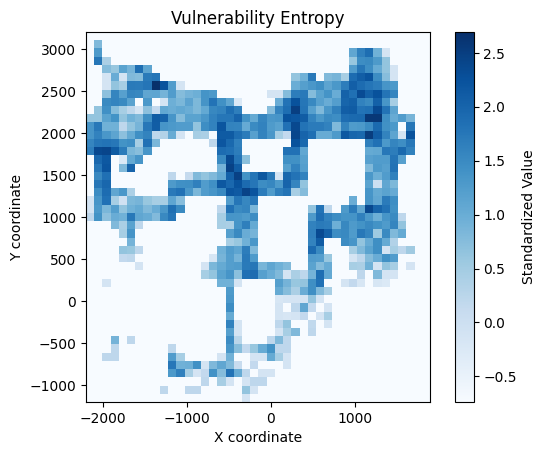

In [37]:
analysis = Gun_Fight_Analysis()
att_position_ent = analysis.num_death_att_entropy(death_dfs)
plot_pixel_map(att_position_ent, 100, title="Vulnerability Entropy")

In [33]:
att_position_ent = processor.num_death_att_entropy(death_dfs)
plot_pixel_map(att_position_ent, 100, title="Entropy")

AttributeError: 'Gun_Fight_Analysis' object has no attribute 'num_death_att_entropy'

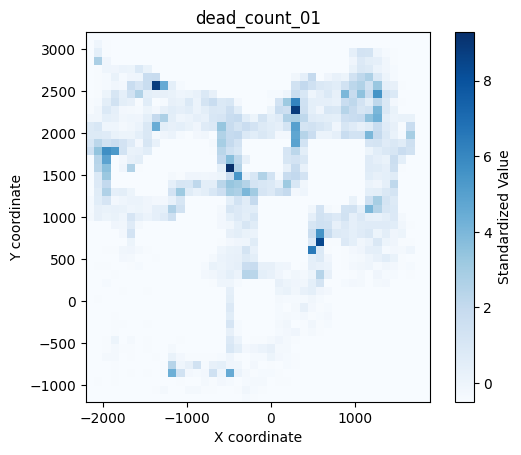

In [5]:
dead_count = processor.num_death_on_map(datas = death_dfs)
plot_pixel_map(dead_count, 100, title="dead_count_01")

In [80]:
# area_todo = ((min_x, max_x), (500, max_y))
area_todo = None
win_rate = processor.win_rate_of_fights(death_dfs, area_todo)

In [76]:
print(type(win_rate))
for key, value in win_rate.items():
    if value == 1:
        # Delete the key
        win_rate[key] = 0

<class 'dict'>


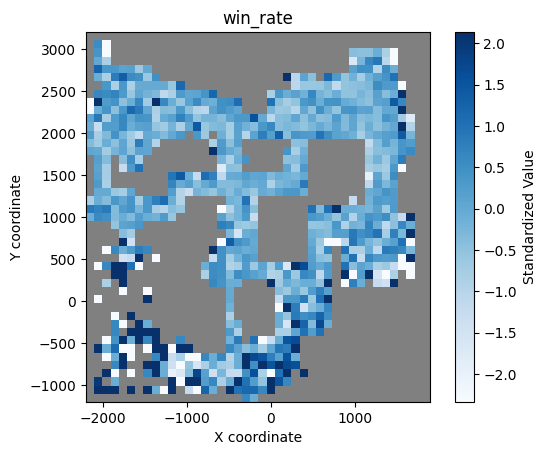

In [81]:
plot_pixel_map(win_rate, 100, title="win_rate")

In [43]:
from models import Expected_Win_Rate
xWinRate = Expected_Win_Rate()

In [46]:
demo_path = r"X:\code\CSGO_AI\demo_analysis\demo\demos_extracted\de_dust2\g2-vs-vitality-m1-dust2.dem"
xWinRate.load_sample_demo(demo_path=demo_path)

{2: {'m0NESY', 'NiKo', 'nexa', 'huNter-', 'Stewie2K'}, 3: {'mezii', 'ZywOo', 'flameZ', 'Spinx', 'apEX'}}


In [64]:
for i in range(0, 30):
    X = xWinRate.gather_predict_sample(i)
# X = xWinRate.gather_predict_sample(19)

flash: 4.818277835845947
flash: 0.970691978931427
flash: 4.166345119476318
flash: 4.4408416748046875
flash: 4.612092018127441
flash: 4.064682483673096
flash: 0.6653169989585876
flash: 0.9843369126319885
flash: 4.896617889404297
flash: 1.0326908826828003
flash: 3.1179912090301514
flash: 3.1179912090301514
flash: 0.7774417996406555
flash: 0.8042446374893188
flash: 2.4132440090179443
flash: 3.3302001953125
flash: 3.390413999557495
flash: 1.302734375
flash: 3.0807135105133057


In [60]:
from models import xFight_Neural_Network, xFight_Logistic_Regression, train
# xfight = xFight_Neural_Network()
# xfight_LR = xFight_Logistic_Regression()
data_path = r'intermediate_data\model_training\19'
# xfight.model_training(data_path)
# xfight_LR.model_training(data_path)

player_map = train(data_path)

intermediate_data\model_training\19\data.txt
the length of the dataframe: 9907
value counts: 120
0    4955
1    4952
Name: count, dtype: int64
9907


x:\conda_environment\CSGO_AI\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Log Loss: 0.5504613050965752
Test Log Loss: 0.5519834783771898
Test Accuracy: 0.7124117053481333
Test Confusion Matrix:
[[706 287]
 [283 706]]
{2: {'Norwi', 'KENSI', 'r3salt', 'deko', 'Lack1'}, 3: {'sh1ro', 'chopper', 'donk', 'magixx', 'zont1x'}}
['KENSI', 'donk', 'r3salt', 'Lack1', 'Norwi', 'sh1ro', 'chopper', 'deko', 'magixx', None, 'zont1x']
entered a valid player name: True
win_times 19
total_times 34
KENSI expected to win 0.5588235294117647, actually won 0.47058823529411764
win_times 20
total_times 34
donk expected to win 0.5882352941176471, actually won 0.5294117647058824
win_times 11
total_times 27
r3salt expected to win 0.4074074074074074, actually won 0.4444444444444444
win_times 14
total_times 29
Lack1 expected to win 0.4827586206896552, actually won 0.5172413793103449
win_times 5
total_times 19
Norwi expected to win 0.2631578947368421, actually won 0.3157894736842105
win_times 23
total_times 29
sh1ro expected to win 0.7931034482758621, actually won 0.586206896551724

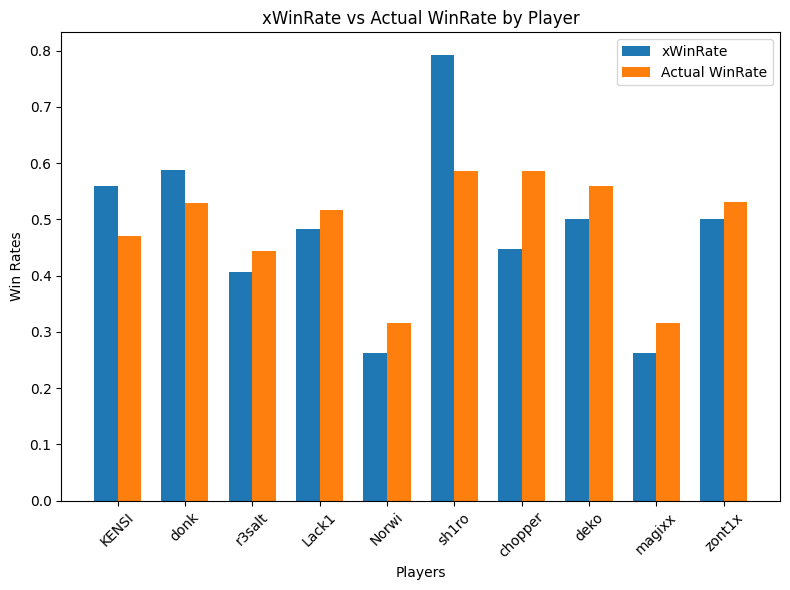

In [71]:
team_map = {2: {'Norwi', 'KENSI', 'r3salt', 'deko', 'Lack1'}, 3: {'sh1ro', 'chopper', 'donk', 'magixx', 'zont1x'}}
player_stats_map = player_map
team_2_stats = {player: player_stats_map[player] for player in team_map[2]}
team_3_stats = {player: player_stats_map[player] for player in team_map[3]}
from plot_module import player_xWinRate_vs_actualWinRate
player_xWinRate_vs_actualWinRate(player_stats_map)

flash: 3.3302001953125
predicted winning probability:  [0.77445364]


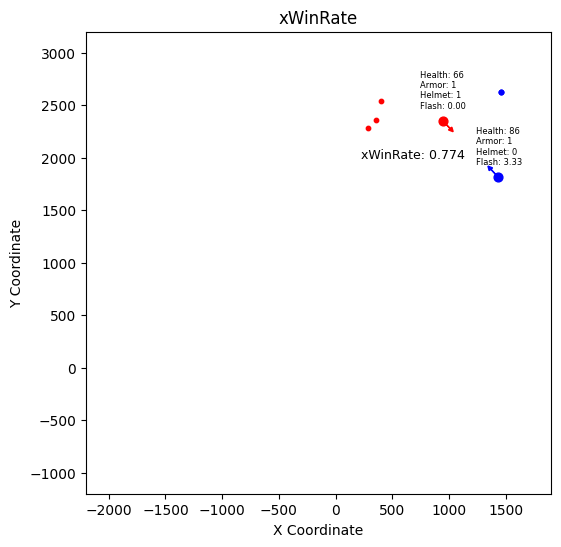

In [69]:
from plot_module import visualize_X
X = xWinRate.gather_predict_sample(21)
out_prob = xfight.predict_w_model(X, True)

print("predicted winning probability: ", 1-out_prob)
visualize_X(X, 1-out_prob.item(), "xWinRate")